In [2]:
%matplotlib inline
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
# from keras.backend import tensorflow_backend as KTF
# import tensorflow as tf
# KTF.set_session(tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=.3333), 
#                                                  device_count={'CPU':8, 'GPU':4})))
from sklearn.model_selection import StratifiedKFold
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktensor import dtensor, cp_als
from tensorly.decomposition import tucker
from tensorly import tucker_to_tensor
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import preprocessing
from joblib import Parallel, delayed
from random import shuffle as shuffle_array
from random import randint

Using TensorFlow backend.


## Preprocessing

In [6]:
def load_df_labels(filename):
    df = pd.read_csv(filename)
    
    print('label', '\t  count', '\t activity')
    for idx, act in enumerate(df.activity_label.unique()): print(idx, '\t ', \
                                                                 df.activity_label.value_counts()[act], '\t', act)
    df['activity_label'] = pd.factorize(df.activity_label)[0]
    print ("\nNumber of Activities with both Accelerometer and Gyroscope:", df.activity_label.nunique())
    
    col_sensors = [u'a_x', u'a_y', u'a_z', u'a_mag', u'g_x', u'g_y', u'g_z', u'g_mag']
    labels = df['activity_label']
    df_data = df.ix[:,col_sensors]
    
    N_samples = df.shape[0] / 200
    print ('Number of blocks of 3D data at 200hz:', N_samples)
    
    return df_data, labels, N_samples

In [331]:
# Loading labels for CP (dataframes have no labels)
dummy1, labels, N_samples = load_df_labels('j4_raw_ag.csv')

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping
8 	  72200 	 TreadmillRunning

Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968


In [333]:
X_4Dcuboid_test = dummy1.as_matrix().reshape(N_samples, 200, 2, 4)

## Visualizing slices of a tensor

In [334]:
t = 0
tensor_t = X_4Dcuboid_test[t,:,:,:]
print ("Tensor shape:", tensor_t[:,:,:].shape)
print ("\nTensor sliced by axes:")
pd.DataFrame(tensor_t[:,:,3], columns=['a_mag', 'g_mag']).head() #Slice per axes

Tensor shape: (200, 2, 4)

Tensor sliced by axes:


,a_mag,g_mag
0,9.810511,0.297657
1,9.567180,0.457419
2,9.328307,0.758711
3,9.140564,1.073671
4,9.078041,1.337396


In [335]:
print ("\nTensor sliced by sensor:")
pd.DataFrame(tensor_t[:,0,:], columns=['a_x', 'a_y', 'a_z', 'a_mag']).head() #Slice per sensor


Tensor sliced by sensor:


,a_x,a_y,a_z,a_mag
0,0.231619,-9.330007,-3.023813,9.810511
1,0.440666,-9.206701,-2.563868,9.567180
2,0.658641,-9.070715,-2.075001,9.328307
3,0.859953,-8.953093,-1.628657,9.140564
4,0.994710,-8.918320,-1.372935,9.078041


## Model for Matrix inputs

In [10]:
N_features = 40
def DeepID_matrix(nb_classes, img_rows=8, img_cols=200, print_layers=True):
    nb_pool = 2
    ###############################################################
    ###############################################################
    model = Sequential()
    model.add(Convolution2D(20,1,10,border_mode='same', input_shape=(img_rows, img_cols, 1)))
    model.add(Activation('relu'))
    if print_layers: print(model.output_shape)
    model.add(Convolution2D(40, 4, 10,border_mode='same',dim_ordering='tf'))
    model.add(Activation('tanh'))
    if print_layers: print(model.output_shape)
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))
    if print_layers: print(model.output_shape)
    model.add(Flatten())
    if print_layers: print(model.output_shape)
    model.add(Dense(N_features))
    if print_layers: print(model.output_shape)
    model.add(Activation('tanh'))
#     model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    return model


def train_network(X_train, X_test, Y_train, Y_test, nb_classes):
    with tf.device('/cpu:0'):
        model = DeepID_matrix(nb_classes, print_layers=False)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X_train, Y_train, batch_size=128, validation_split=0.125, nb_epoch=20, verbose=False)
        score = model.evaluate(X_test, Y_test, verbose=False)
        print('Test score:', score[0])
        print('Test accuracy:', score[1])
        # model.summary()
    return model, score[1]

## Training Phases

In [5]:
df, labels, N_samples = load_df_labels('j4_raw_ag.csv')
    
y_train_test = labels.as_matrix().reshape(N_samples, 1, 200, 1)
col_sensors = [u'a_x', u'a_y', u'a_z', u'a_mag', u'g_x', u'g_y', u'g_z', u'g_mag']
X_train_test = df.ix[:, col_sensors].as_matrix().reshape(N_samples, 8, 200, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, \
                                                    random_state=0, test_size=0.3)
nb_classes = labels.nunique()

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping
8 	  72200 	 TreadmillRunning

Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968


In [7]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_train.shape

(11177, 1, 200, 1)

In [8]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_train.shape

(11177, 9)

In [4]:
def train_raw(filename, shuffle_state=0):
    df, labels, N_samples = load_df_labels(filename)
    
    y_train_test = labels.as_matrix().reshape(N_samples, 1, 200, 1)
    col_sensors = [u'a_x', u'a_y', u'a_z', u'a_mag', u'g_x', u'g_y', u'g_z', u'g_mag']
    X_train_test = df.ix[:, col_sensors].as_matrix().reshape(N_samples, 8, 200, 1)
    X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, \
                                                        random_state=shuffle_state, test_size=0.3)
    nb_classes = labels.nunique()
    # Convert class vectors to binary class matrices.
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    
    model, accuracy = train_network(X_train, X_test, Y_train, Y_test, nb_classes)
    
    y_pred = model.predict_classes(X_test, verbose=False)

    fig, ax = plt.subplots(figsize=(7,4)) 
    df_results = pd.DataFrame(data=np.column_stack((y_test[:,0,0,0],y_pred)),columns=['True','Predicted'])
    CT_results = pd.crosstab(df_results.True,df_results.Predicted).apply(lambda r: r/r.sum(), axis=1)
    sns.heatmap(CT_results, annot=True, fmt=".2f", linewidths=.5,ax=ax)
    
    print(model.summary())
    

def train_cp(filename, labels, shuffle_state=0):
    df = pd.read_csv(filename)
    
    y_train_test = labels.as_matrix().reshape(N_samples, 1, 200, 1)
    col_sensors = [u'a_x', u'a_y', u'a_z', u'a_mag', u'g_x', u'g_y', u'g_z', u'g_mag']
    X_train_test = df.ix[:, col_sensors].as_matrix().reshape(N_samples, 8, 200, 1)
    X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, \
                                                        random_state=shuffle_state, test_size=0.3)
    nb_classes = labels.nunique()
    # Convert class vectors to binary class matrices.
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    
    model, accuracy = train_network(X_train, X_test, Y_train, Y_test, nb_classes)
    
    y_pred = model.predict_classes(X_test, verbose=False)

    fig, ax = plt.subplots(figsize=(7,4)) 
    df_results = pd.DataFrame(data=np.column_stack((y_test[:,0,0,0],y_pred)),columns=['True','Predicted'])
    CT_results = pd.crosstab(df_results.True,df_results.Predicted).apply(lambda r: r/r.sum(), axis=1)
    sns.heatmap(CT_results, annot=True, fmt=".2f", linewidths=.5,ax=ax)
    
    print(model.summary())
    

## Training Raw vs. Scaled

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping
8 	  72200 	 TreadmillRunning

Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968
(None, 8, 200, 20)
(None, 8, 200, 40)
(None, 4, 100, 40)
(None, 16000)
(None, 40)
Train on 9779 samples, validate on 1398 samples
Epoch 1/20
9779/9779 [==============================] - 2s - loss: 1.1682 - acc: 0.6127 - val_loss: 0.6850 - val_acc: 0.7833
Epoch 2/20
9779/9779 [==============================] - 1s - loss: 0.6382 - acc: 0.7922 - val_loss: 0.5128 - val_acc: 0.8298
Epoch 3/20
9779/9779 [==============================] - 1s - loss: 0.4926 - acc: 0.8440 - val_loss: 0.3978 - val_acc: 0.8770
Epoch 4/20
9779/9779 [==============================] - 1s - loss: 0.3951 - acc: 0.8767 - val_loss: 0.3408 - val_acc: 0.9013
Epoch 5/20
9779/9779 [=====

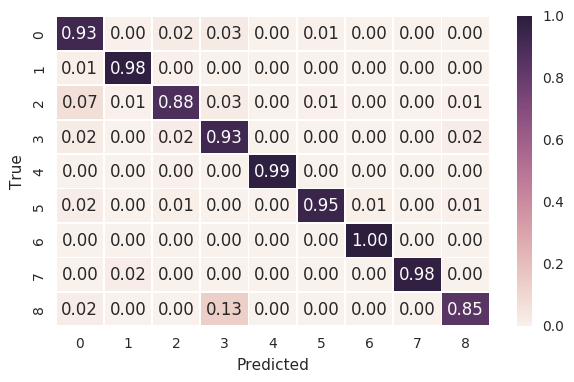

In [7]:
train_raw('j4_raw_ag.csv', shuffle_state=42)

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping
8 	  72200 	 TreadmillRunning

Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968
(None, 8, 200, 20)
(None, 8, 200, 40)
(None, 4, 100, 40)
(None, 16000)
(None, 40)
Train on 9779 samples, validate on 1398 samples
Epoch 1/20
9779/9779 [==============================] - 2s - loss: 1.3431 - acc: 0.5442 - val_loss: 0.7118 - val_acc: 0.7754
Epoch 2/20
9779/9779 [==============================] - 1s - loss: 0.5764 - acc: 0.8184 - val_loss: 0.4482 - val_acc: 0.8505
Epoch 3/20
9779/9779 [==============================] - 1s - loss: 0.3592 - acc: 0.8892 - val_loss: 0.3749 - val_acc: 0.8763
Epoch 4/20
9779/9779 [==============================] - 1s - loss: 0.2553 - acc: 0.9249 - val_loss: 0.3193 - val_acc: 0.8977
Epoch 5/20
9779/9779 [=====

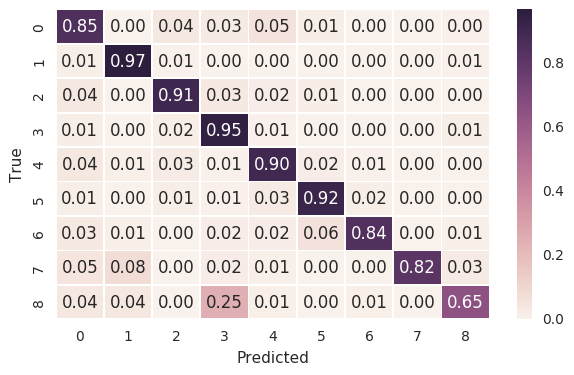

In [8]:
train_raw('j4_scaled_ag.csv', shuffle_state=42)

## CP Decomposition

In [30]:
def compress_tensor_CP(T_in, n_cp):
    '''Create dense tensor from numpy array
    Input is a 3-way numpy.ndarray
    ex: T_in = np.random.rand(3, 50, 4)
    '''
    T = dtensor(T_in)
    P, fit, itr, exectimes = cp_als(T, n_cp, init='random')
    #The quality of the reconstructed signal is measured as the 
    # percent-root mean square distortion (PRD):
    T1 = P.toarray()
    prd = np.sqrt(((T_in-T1)**2).sum()/(T_in**2).sum())*100.0
    cmpr_ratio = 100 - 100.0 * (P.U[0].size + P.U[1].size + P.U[2].size + P.lmbda.size) / T_in.size
    T_out = np.array(T1)
    return T_out, prd, cmpr_ratio


def compress_dataframe_CP(df, n_cp):
    # Number of blocks of 3D data at 200hz:
    dimension = df.shape[0] / 200
    # Compression rate
    cr_vec = np.zeros((dimension,1),dtype='float')
    # Percent-Root mean squared Distortion (reconstruction to original)
    prd_vec = np.zeros((dimension,1),dtype='float')
    df_compress = pd.DataFrame()
    for t_ind in tqdm(range(dimension)):
        tensor_t = X_4Dcuboid[t_ind,:,:,:]
        T_out, prd, cmpr_ratio = compress_tensor_CP(tensor_t, n_cp)
        df_compress_t = pd.DataFrame(T_out.reshape((200, 8)), columns=[u'a_x', u'a_y', u'a_z', u'a_mag', \
                                                                       u'g_x', u'g_y',  u'g_z', u'g_mag'])
        df_compress = df_compress.append(df_compress_t, ignore_index=True)
        prd_vec[t_ind] = prd
        cr_vec[t_ind] = cmpr_ratio
    print ("Compression Rate:", "{0:.2f}".format(np.mean(cr_vec)))
    print ("Root Mean Squared Distortion between tensor reconstruction and original tensor:", \
            "{0:.3f}%".format(np.mean(prd_vec)))
    return df_compress, prd_vec, cr_vec


## Option 1: Parallelized
# def main(df, i):
#     print ('Rank: ', i)
#     df_compress1k, prd, cr = compress_dataframe_CP(df, i)
#     return (i, np.mean(prd), np.mean(cr))
# Parallel(n_jobs=1)(delayed(main)(df_data, i) for i in range(1,9))

# # Option 2: Regular Loop
# prd_bundle = []
# cr_bundle = []
# for i in range(1,9):
#     print ('Rank:', i)
#     df_compress_tmp, prd, cr = compress_dataframe_CP(df_data, i)
#     prd_bundle.append(np.mean(prd))
#     cr_bundle.append(np.mean(cr))
#     df_compress_tmp.to_csv('raw_j4_ag_cp' + str(i) + '.csv', index=False)

(None, 8, 200, 20)
(None, 8, 200, 40)
(None, 4, 100, 40)
(None, 16000)
(None, 40)
Train on 9779 samples, validate on 1398 samples
Epoch 1/20
9779/9779 [==============================] - 2s - loss: 1.7503 - acc: 0.4132 - val_loss: 1.3422 - val_acc: 0.6531
Epoch 2/20
9779/9779 [==============================] - 1s - loss: 1.1625 - acc: 0.6940 - val_loss: 1.0181 - val_acc: 0.7089
Epoch 3/20
9779/9779 [==============================] - 1s - loss: 0.9289 - acc: 0.7245 - val_loss: 0.7744 - val_acc: 0.7797
Epoch 4/20
9779/9779 [==============================] - 1s - loss: 0.7430 - acc: 0.7738 - val_loss: 0.6291 - val_acc: 0.8011
Epoch 5/20
9779/9779 [==============================] - 1s - loss: 0.6330 - acc: 0.8061 - val_loss: 0.5345 - val_acc: 0.8526
Epoch 6/20
9779/9779 [==============================] - 1s - loss: 0.5226 - acc: 0.8384 - val_loss: 0.4797 - val_acc: 0.8612
Epoch 7/20
9779/9779 [==============================] - 1s - loss: 0.4451 - acc: 0.8678 - val_loss: 0.3607 - val_acc: 0.

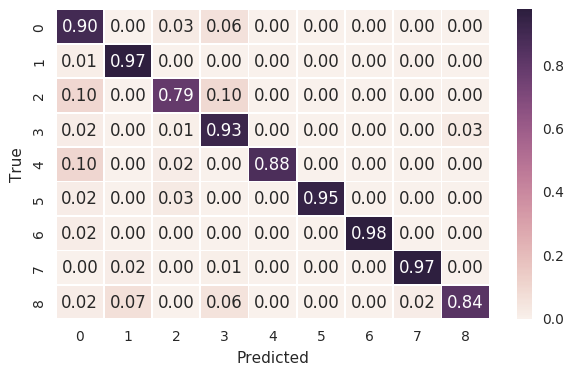

In [14]:
train_cp('raw_j4_ag_cp4.csv', labels, shuffle_state=42)

(None, 8, 200, 20)
(None, 8, 200, 40)
(None, 4, 100, 40)
(None, 16000)
(None, 40)
Train on 9779 samples, validate on 1398 samples
Epoch 1/20
9779/9779 [==============================] - 2s - loss: 1.5356 - acc: 0.4322 - val_loss: 1.1819 - val_acc: 0.6438
Epoch 2/20
9779/9779 [==============================] - 1s - loss: 0.9778 - acc: 0.6807 - val_loss: 0.7307 - val_acc: 0.7718
Epoch 3/20
9779/9779 [==============================] - 1s - loss: 0.6360 - acc: 0.7957 - val_loss: 0.6246 - val_acc: 0.8011
Epoch 4/20
9779/9779 [==============================] - 1s - loss: 0.5825 - acc: 0.7971 - val_loss: 0.5358 - val_acc: 0.8369
Epoch 5/20
9779/9779 [==============================] - 2s - loss: 0.4569 - acc: 0.8531 - val_loss: 0.4071 - val_acc: 0.8698
Epoch 6/20
9779/9779 [==============================] - 2s - loss: 0.3850 - acc: 0.8786 - val_loss: 0.3166 - val_acc: 0.9013
Epoch 7/20
9779/9779 [==============================] - 2s - loss: 0.3407 - acc: 0.8902 - val_loss: 0.2924 - val_acc: 0.

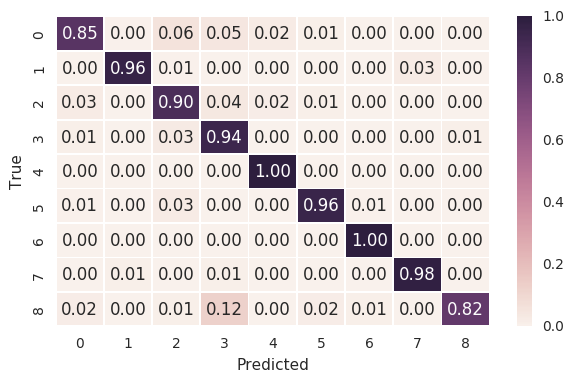

In [28]:
train_cp('raw_j4_ag_cp4.csv', labels, shuffle_state=42)

(None, 8, 200, 20)
(None, 8, 200, 40)
(None, 4, 100, 40)
(None, 16000)
(None, 40)
Train on 9779 samples, validate on 1398 samples
Epoch 1/20
9779/9779 [==============================] - 2s - loss: 1.5870 - acc: 0.4524 - val_loss: 1.0480 - val_acc: 0.6144
Epoch 2/20
9779/9779 [==============================] - 2s - loss: 0.7841 - acc: 0.7427 - val_loss: 0.5659 - val_acc: 0.8069
Epoch 3/20
9779/9779 [==============================] - 2s - loss: 0.5312 - acc: 0.8292 - val_loss: 0.4223 - val_acc: 0.8763
Epoch 4/20
9779/9779 [==============================] - 1s - loss: 0.4235 - acc: 0.8637 - val_loss: 0.3529 - val_acc: 0.9049
Epoch 5/20
9779/9779 [==============================] - 1s - loss: 0.3886 - acc: 0.8741 - val_loss: 0.3103 - val_acc: 0.9163
Epoch 6/20
9779/9779 [==============================] - 1s - loss: 0.3114 - acc: 0.9046 - val_loss: 0.2973 - val_acc: 0.9063
Epoch 7/20
9779/9779 [==============================] - 1s - loss: 0.2906 - acc: 0.9081 - val_loss: 0.2654 - val_acc: 0.

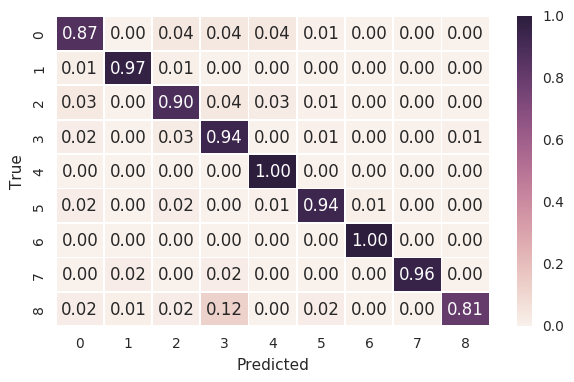

In [15]:
train_cp('raw_j4_ag_cp5.csv', labels, shuffle_state=42)

## Tucker Decomposition

In [29]:
def compress_tensor_tucker(T_in, ranks=[200, 2, 4]):
    '''Tucker'''
    core, factors = tucker(T_in, ranks)
    #The quality of the reconstructed signal is measured as the 
    # percent-root mean square distortion (PRD):
    T1 = tucker_to_tensor(core, factors)
    prd = np.sqrt(((T_in-T1)**2).sum()/(T_in**2).sum())*100.0
    cmpr_ratio = 100 - 100.0 * (core[:,:,:].size) / T_in.size
    T_out = np.array(T1)
    return core, T_out, prd, cmpr_ratio


def compress_dataframe_tucker(df, rank=[200, 2, 4]):
    # Number of blocks of 3D data at 200hz:
    dimension = df.shape[0] / 200
    # Compression rate
    cr_vec = np.zeros((dimension,1),dtype='float')
    # Percent-Root mean squared Distortion (reconstruction to original)
    prd_vec = np.zeros((dimension,1),dtype='float')
    df_compress = pd.DataFrame()
    
    X_4Dcuboid = df.as_matrix().reshape(dimension, 200, 2, 4)
    
    # Initializing first 2 tensors
    tensor_0 = X_4Dcuboid[0,:,:,:]
    core0, T_out, prd, cmpr_ratio = compress_tensor_tucker(tensor_0, rank)
    prd_vec[0] = prd
    cr_vec[0] = cmpr_ratio
    df_compress_t = pd.DataFrame(T_out.reshape((200, 8)), columns=[u'a_x', u'a_y', u'a_z', u'a_mag', \
                                                                        u'g_x', u'g_y', u'g_z', u'g_mag'])
    df_compress = df_compress.append(df_compress_t, ignore_index=True)
    
    tensor_1 = X_4Dcuboid[1,:,:,:]
    core1, T_out, prd, cmpr_ratio = compress_tensor_tucker(tensor_1, rank)
    prd_vec[1] = prd
    cr_vec[1] = cmpr_ratio
    df_compress_t = pd.DataFrame(T_out.reshape((200, 8)), columns=[u'a_x', u'a_y', u'a_z', u'a_mag', \
                                                                        u'g_x', u'g_y', u'g_z', u'g_mag'])
    df_compress = df_compress.append(df_compress_t, ignore_index=True)
    
    cores_tensor = np.concatenate((core0[np.newaxis, ...], core1[np.newaxis, ...]), axis=0)
    
    for t_ind in tqdm(xrange(2, dimension)):
        tensor_t = X_4Dcuboid[t_ind,:,:,:]
        core, T_out, prd, cmpr_ratio = compress_tensor_tucker(tensor_t, rank)
        
        df_compress_t = pd.DataFrame(T_out.reshape((200, 8)), columns=[u'a_x', u'a_y', u'a_z', u'a_mag', \
                                                                        u'g_x', u'g_y', u'g_z', u'g_mag'])
        df_compress = df_compress.append(df_compress_t, ignore_index=True)
        
        cores_tensor = np.concatenate((cores_tensor, core[np.newaxis, ...]), axis=0)
        
        prd_vec[t_ind] = prd
        cr_vec[t_ind] = cmpr_ratio
        
    print ("Compression Rate:", "{0:.2f}".format(np.mean(cr_vec)))
    print ("Root Mean Squared Distortion between tensor reconstruction and original tensor:", \
            "{0:.3f}%".format(np.mean(prd_vec)))
    return cores_tensor, df_compress, prd_vec, cr_vec

In [28]:
def DeepID_tensor(nb_classes, img_rows=10, img_cols=4, img_channels=2, print_layers=False):
    # size of pooling area for max pooling
    nb_pool = 2
    ###############################################################
    ###############################################################
    model = Sequential()
    model.add(Convolution2D(20,1,10,border_mode='same',input_shape=(img_rows, img_cols, img_channels)))
    model.add(Activation('relu'))
    if print_layers: print(model.output_shape)
    model.add(Convolution2D(40, 4, 10,border_mode='same',dim_ordering='tf'))
    model.add(Activation('tanh'))
    if print_layers: print(model.output_shape)
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))
    if print_layers: print(model.output_shape)
    model.add(Flatten())
    if print_layers: print(model.output_shape)
    model.add(Dense(N_features))
    if print_layers: print(model.output_shape)
    model.add(Activation('tanh'))
#     model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    return model


def train_tensor_network(X_train, X_test, Y_train, Y_test, labels, nb_classes, rank):
    with tf.device('/gpu:0'):
        model = DeepID_tensor(nb_classes, rank[0], rank[1], rank[2], print_layers=False)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X_train, Y_train, batch_size=128, validation_split=0.125, nb_epoch=20, verbose=False)
        score = model.evaluate(X_test, Y_test, verbose=False)
        print('Test score:', score[0])
        print('Test accuracy:', score[1])
        # model.summary()
    return model, score[1]


# def main(df_data, rank, plot=False, return_reconstruction=False):
#     cores_tensor, df_compress, prd, cr = compress_dataframe(df_data, rank)
#     X_train, X_test, Y_train, Y_test, y_test = prepare_X_Y(cores_tensor)
#     model, accuracy = train_network(X_train, X_test, Y_train, Y_test, rank)
#     y_pred = model.predict_classes(X_test, verbose=False)
#     #     print('Test Score', y_pred==y_test).sum()/float(len(y_test))
#     if plot:
#         fig, ax = plt.subplots(figsize=(7,4)) 
#         df_results = pd.DataFrame(data=np.column_stack((y_test,y_pred)),columns=['True','Predicted'])
#         CT_results = pd.crosstab(df_results.True,df_results.Predicted).apply(lambda r: r/r.sum(), axis=1)
#         sns.heatmap(CT_results, annot=True, fmt=".2f", linewidths=.5,ax=ax)
#         plt.show()
#     if return_reconstruction: return model, accuracy, np.mean(cr), df_compress
#     return model, accuracy, np.mean(cr)

In [312]:
def train_tucker(filename, rank, train_on='reconstruction', plot=False, shuffle_state=42):
    '''INPUT: filename (DataFrame to be read containing ax, ay, az, amag, gx, gy, gz, gmag)
              rank (dimensions for Tucker decomposition)
              train_on (default='reconstruction' makes a matrix com Tucker's core; or 'core' trains
            on the core itself)
              plot=False or True to plot confusion matrix
              shuffle_state takes any int to reproduce experiments
    '''
    df_data, labels, N_samples = load_df_labels(filename)
    nb_classes = labels.nunique()
    
    # Tucker decomposition
    cores_tensor, df_compress, prd, cr = compress_dataframe_tucker(df_data, rank)
    
    if train_on == 'core':
        # Extracting labels for each 200hz 3D block to match tensor slices
        y_train_test = []
        for i in xrange(N_samples):
            y_train_test.append(labels.ix[200*i:200*(i+1)].values[0])
        y_train_test = np.array(y_train_test).reshape((N_samples, 1))
        
        # Prepare X's and Y'x
        X_train_test = cores_tensor
        X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.3, \
                                                            random_state=shuffle_state)
        # Convert class vectors to binary class matrices.
        Y_train = np_utils.to_categorical(y_train, nb_classes)
        Y_test = np_utils.to_categorical(y_test, nb_classes)

        model, accuracy = train_tensor_network(X_train, X_test, Y_train, Y_test, labels, nb_classes, rank)
        y_pred = model.predict_classes(X_test, verbose=False)
        df_results = pd.DataFrame(data=np.column_stack((y_test,y_pred)),columns=['True','Predicted'])

    if train_on == 'reconstruction':
        y_train_test = labels.as_matrix().reshape(N_samples, 1, 200, 1)
        X_train_test = df_compress.as_matrix().reshape(N_samples, 8, 200, 1)
        X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, \
                                                            random_state=shuffle_state, test_size=0.3)
        
        # Convert class vectors to binary class matrices.
        Y_train = np_utils.to_categorical(y_train, nb_classes)
        Y_test = np_utils.to_categorical(y_test, nb_classes)

        model, accuracy = train_network(X_train, X_test, Y_train, Y_test, nb_classes)
        y_pred = model.predict_classes(X_test, verbose=False)
        df_results = pd.DataFrame(data=np.column_stack((y_test[:,0,0,0],y_pred)),columns=['True','Predicted'])

    if plot:
        fig, ax = plt.subplots(figsize=(7,4)) 
        CT_results = pd.crosstab(df_results.True,df_results.Predicted).apply(lambda r: r/r.sum(), axis=1)
        sns.heatmap(CT_results, annot=True, fmt=".2f", linewidths=.5,ax=ax)
        plt.show()
        
    print(model.summary())

    return model, accuracy, np.mean(cr)

In [26]:
train_tucker('j4_raw_ag.csv', rank=[10, 2, 4], train_on='core', plot=False, shuffle_state=198) #2

  1%|          | 11/1248 [00:00<00:11, 107.19it/s]

label 	  count 	 activity
0 	  76200 	 Downstairs
1 	  117200 	 Running
2 	  56600 	 Upstairs

Number of Activities with both Accelerometer and Gyroscope: 3
Number of blocks of 3D data at 200hz: 1250


100%|██████████| 1248/1248 [00:19<00:00, 62.77it/s]


Compression Rate: 95.00
Root Mean Squared Distortion between tensor reconstruction and original tensor: 0.000%
Test score: 0.240211326083
Test accuracy: 0.914666667302


(<keras.models.Sequential at 0x7f63b1721e90>, 0.9146666673024495, 95.0)

In [27]:
train_tucker('j4_raw_ag.csv', rank=[10, 2, 4], train_on='core', plot=False, shuffle_state=198) #1

  0%|          | 5/1248 [00:00<00:25, 49.06it/s]

label 	  count 	 activity
0 	  76200 	 Downstairs
1 	  117200 	 Running
2 	  56600 	 Upstairs

Number of Activities with both Accelerometer and Gyroscope: 3
Number of blocks of 3D data at 200hz: 1250


100%|██████████| 1248/1248 [00:15<00:00, 78.22it/s]


Compression Rate: 95.00
Root Mean Squared Distortion between tensor reconstruction and original tensor: 0.000%
Test score: 0.215197955728
Test accuracy: 0.936000000636


(<keras.models.Sequential at 0x7f639fc90b90>, 0.93600000063578292, 95.0)

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping
8 	  72200 	 TreadmillRunning

Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968


100%|██████████| 15966/15966 [07:37<00:00, 20.24it/s]


Compression Rate: 95.00
Root Mean Squared Distortion between tensor reconstruction and original tensor: 0.000%
Test score: 0.342338770423
Test accuracy: 0.885201419427


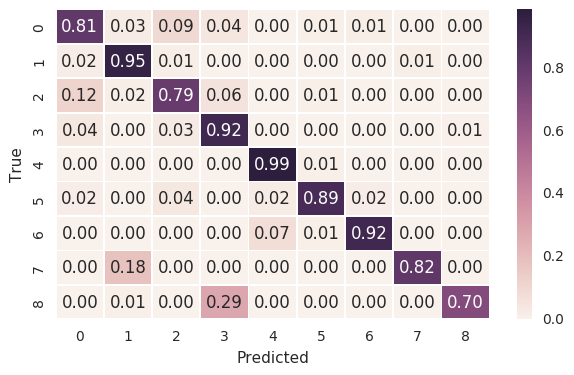

(<keras.models.Sequential at 0x7f27195a0650>, 0.88520141942743413, 95.0)

In [19]:
train_tucker('j4_raw_ag.csv', rank=[10, 2, 4], train_on='core', plot=True, shuffle_state=42)

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping
8 	  72200 	 TreadmillRunning


  0%|          | 9/15966 [00:00<03:07, 84.90it/s]


Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968


100%|██████████| 15966/15966 [43:08<00:00,  3.14it/s]


Compression Rate: 95.00
Root Mean Squared Distortion between tensor reconstruction and original tensor: 0.000%
(None, 8, 200, 20)
(None, 8, 200, 40)
(None, 4, 100, 40)
(None, 16000)
(None, 40)
Train on 9779 samples, validate on 1398 samples
Epoch 1/20
9779/9779 [==============================] - 2s - loss: 1.5325 - acc: 0.4797 - val_loss: 1.1295 - val_acc: 0.6266
Epoch 2/20
9779/9779 [==============================] - 1s - loss: 0.8935 - acc: 0.7144 - val_loss: 0.6961 - val_acc: 0.7725
Epoch 3/20
9779/9779 [==============================] - 1s - loss: 0.5857 - acc: 0.8223 - val_loss: 0.4265 - val_acc: 0.8841
Epoch 4/20
9779/9779 [==============================] - 1s - loss: 0.4525 - acc: 0.8628 - val_loss: 0.4581 - val_acc: 0.8491
Epoch 5/20
9779/9779 [==============================] - 1s - loss: 0.3672 - acc: 0.8871 - val_loss: 0.3145 - val_acc: 0.9034
Epoch 6/20
9779/9779 [==============================] - 1s - loss: 0.3315 - acc: 0.8958 - val_loss: 0.3185 - val_acc: 0.8999
Epoch 7/2

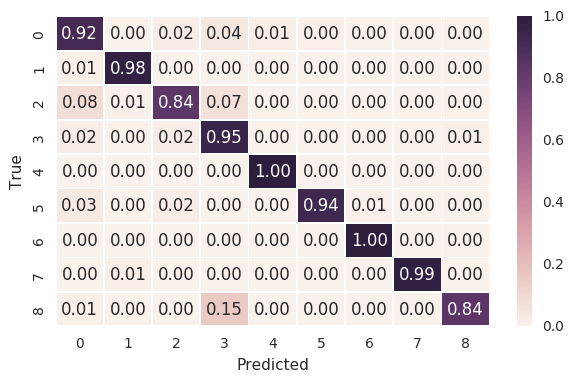

(<keras.models.Sequential at 0x7f2718584610>, 0.93571279483606862, 95.0)

In [24]:
train_tucker('j4_raw_ag.csv', rank=[10, 2, 4], train_on='reconstruction', plot=True, shuffle_state=42)

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping


  0%|          | 0/15966 [00:00<?, ?it/s]

8 	  72200 	 TreadmillRunning

Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968


100%|██████████| 15966/15966 [09:08<00:00, 16.62it/s]


Compression Rate: 90.00
Root Mean Squared Distortion between tensor reconstruction and original tensor: 0.000%
Test score: 0.327846753936
Test accuracy: 0.89041953678


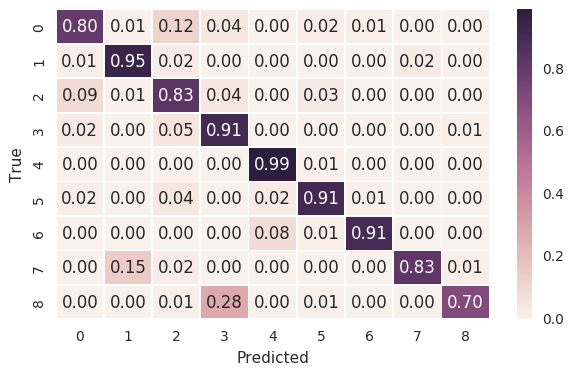

(<keras.models.Sequential at 0x7f2718464cd0>, 0.89041953678047503, 90.0)

In [20]:
train_tucker('j4_raw_ag.csv', rank=[20, 2, 4], train_on='core', plot=True, shuffle_state=42)

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping
8 	  72200 	 TreadmillRunning

Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 

  0%|          | 13/15966 [00:00<02:03, 129.31it/s]

15968


100%|██████████| 15966/15966 [10:14<00:00, 25.96it/s]


Compression Rate: 90.00
Root Mean Squared Distortion between tensor reconstruction and original tensor: 0.000%
(None, 8, 200, 20)
(None, 8, 200, 40)
(None, 4, 100, 40)
(None, 16000)
(None, 40)
Train on 9779 samples, validate on 1398 samples
Epoch 1/20
9779/9779 [==============================] - 2s - loss: 1.4638 - acc: 0.4830 - val_loss: 1.0315 - val_acc: 0.6366
Epoch 2/20
9779/9779 [==============================] - 1s - loss: 0.7790 - acc: 0.7431 - val_loss: 0.6271 - val_acc: 0.8190
Epoch 3/20
9779/9779 [==============================] - 1s - loss: 0.6022 - acc: 0.8029 - val_loss: 0.5292 - val_acc: 0.8362
Epoch 4/20
9779/9779 [==============================] - 1s - loss: 0.5126 - acc: 0.8245 - val_loss: 0.4131 - val_acc: 0.8770
Epoch 5/20
9779/9779 [==============================] - 1s - loss: 0.3985 - acc: 0.8796 - val_loss: 0.3506 - val_acc: 0.8977
Epoch 6/20
9779/9779 [==============================] - 1s - loss: 0.3647 - acc: 0.8844 - val_loss: 0.3004 - val_acc: 0.9056
Epoch 7/2

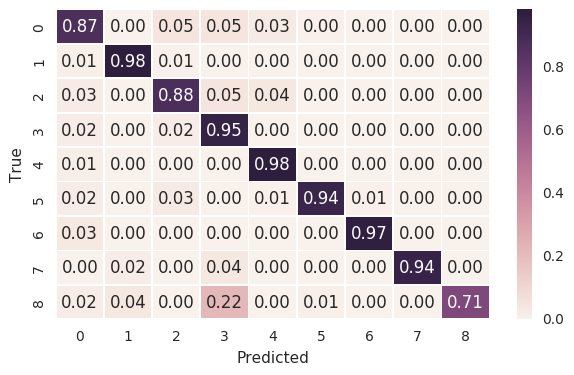

(<keras.models.Sequential at 0x7f27132689d0>, 0.92903360482472463, 90.0)

In [23]:
train_tucker('j4_raw_ag.csv', rank=[20, 2, 4], train_on='reconstruction', plot=True, shuffle_state=42)

## Cross Validation models

In [10]:
def CV_tucker_base(filename, rank):
    df_data, labels, N_samples = load_df_labels(filename)
    nb_classes = labels.nunique()
    
    # Tucker decomposition
    cores_tensor, df_compress, prd, cr = compress_dataframe_tucker(df_data, rank)
    
    return cores_tensor, df_compress, prd, cr, labels, N_samples, nb_classes


def run_tucker_CV_core(core, df_compress, rank, N_samples, nb_classes, labels, train_on='reconstruction', CV=10):
    if train_on == 'core':
        # Extracting labels for each 200hz 3D block to match tensor slices
        y_train_test = []
        for i in xrange(N_samples):
            y_train_test.append(labels.ix[200*i:200*(i+1)].values[0])
        y_train_test = np.array(y_train_test).reshape((N_samples, 1))
        
        # Prepare X's and Y'x
        X_train_test = core
        
        accuracies = {}
        for i in range(CV):
            shuffle_state = randint(1, 200)
            X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.3, \
                                                            random_state=shuffle_state)
            # Convert class vectors to binary class matrices.
            Y_train = np_utils.to_categorical(y_train, nb_classes)
            Y_test = np_utils.to_categorical(y_test, nb_classes)

            model, accuracy = train_tensor_network(X_train, X_test, Y_train, Y_test, labels, nb_classes, rank)
            accuracies[shuffle_state] = accuracy
            print ("{}/{} Done".format(i+1, CV))

    if train_on == 'reconstruction':
        y_train_test = labels.as_matrix().reshape(N_samples, 1, 200, 1)
        X_train_test = df_compress.as_matrix().reshape(N_samples, 8, 200, 1)
        
        accuracies = {}
        for i in range(CV):
            shuffle_state = randint(1, 200)
            X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, \
                                                                random_state=shuffle_state, test_size=0.3)

            # Convert class vectors to binary class matrices.
            Y_train = np_utils.to_categorical(y_train, nb_classes)
            Y_test = np_utils.to_categorical(y_test, nb_classes)

            model, accuracy = train_network(X_train, X_test, Y_train, Y_test, nb_classes)
            accuracies[shuffle_state] = accuracy
            print ("{}/{} Done".format(i+1, CV))

    return accuracies


def tucker_CV(filename, rank, train_on, CV):
    cores_tensor, df_compress, prd, cr, labels, N_samples, nb_classes = CV_tucker_base(filename, rank)
    accuracies = run_tucker_CV_core(cores_tensor, df_compress, rank, N_samples, nb_classes, labels, \
                                    train_on='reconstruction', CV=CV)
    return accuracies

In [ ]:
tucker10_core = tucker_CV('j4_raw_ag.csv', rank=[10, 2, 4], train_on='core', CV=100)
np.save('100cvs_tucker10_core.npy', tucker10_core)

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping


  0%|          | 12/15966 [00:00<02:16, 116.46it/s]

8 	  72200 	 TreadmillRunning

Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968


 50%|█████     | 8058/15966 [02:52<04:42, 27.97it/s]

In [ ]:
tucker10_reconstructed = tucker_CV('j4_raw_ag.csv', rank=[10, 2, 4], train_on='reconstruction', CV=100)
np.save('100cvs_tucker10_reconstructed.npy', tucker10_reconstructed)

In [ ]:
tucker20_core = tucker_CV('j4_raw_ag.csv', rank=[20, 2, 4], train_on='core', CV=100)
np.save('100cvs_tucker20_core.npy', tucker20_core)

In [ ]:
tucker20_reconstructed = tucker_CV('j4_raw_ag.csv', rank=[20, 2, 4], train_on='reconstruction', CV=100)
np.save('100cvs_tucker20_reconstructed.npy', tucker20_reconstructed)

In [86]:
def raw_CV(filename, CV):
    df, labels, N_samples = load_df_labels(filename)
    
    y_train_test = labels.as_matrix().reshape(N_samples, 1, 200, 1)
    col_sensors = [u'a_x', u'a_y', u'a_z', u'a_mag', u'g_x', u'g_y', u'g_z', u'g_mag']
    X_train_test = df.ix[:, col_sensors].as_matrix().reshape(N_samples, 8, 200, 1)
    nb_classes = labels.nunique()
    
    accuracies = {}
    for i in range(CV):
        shuffle_state = randint(1, 200)
        X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, \
                                                            random_state=shuffle_state, test_size=0.3)

        # Convert class vectors to binary class matrices.
        Y_train = np_utils.to_categorical(y_train, nb_classes)
        Y_test = np_utils.to_categorical(y_test, nb_classes)

        model, accuracy = train_network(X_train, X_test, Y_train, Y_test, nb_classes)
        accuracies[shuffle_state] = accuracy
        print ("{}/{} Done".format(i+1, CV))
    
    return accuracies

In [ ]:
raw_accuracies = raw_CV('j4_raw_ag.csv', CV=100)
np.save('100cvs_raw_accuracies.npy', raw_accuracies)

In [ ]:
scaled_accuracies = raw_CV('j4_scaled_ag.csv', CV=100)
np.save('100cvs_scaled_accuracies.npy', scaled_accuracies)

In [181]:
def cp_CV(filename, labels, CV=10):
    df = pd.read_csv(filename)
    nb_classes = labels.nunique()
    
    y_train_test = labels.as_matrix().reshape(N_samples, 1, 200, 1)
    col_sensors = [u'a_x', u'a_y', u'a_z', u'a_mag', u'g_x', u'g_y', u'g_z', u'g_mag']
    X_train_test = df.ix[:, col_sensors].as_matrix().reshape(N_samples, 8, 200, 1)
    
    accuracies = {}
    for i in range(CV):
        shuffle_state = randint(1, 200)
        X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, \
                                                            random_state=shuffle_state, test_size=0.3)

        # Convert class vectors to binary class matrices.
        Y_train = np_utils.to_categorical(y_train, nb_classes)
        Y_test = np_utils.to_categorical(y_test, nb_classes)

        model, accuracy = train_network(X_train, X_test, Y_train, Y_test, nb_classes)
        accuracies[shuffle_state] = accuracy
        print ("{}/{} Done".format(i+1, CV))
    
    return accuracies

In [ ]:
cp5_accuracies = cp_CV('raw_j4_ag_cp5.csv', labels, CV=100)
np.save('100cvs_cp5_accuracies.npy', cp5_accuracies)

cp4_accuracies = cp_CV('raw_j4_ag_cp4.csv', labels, CV=100)
np.save('100cvs_cp4_accuracies.npy', cp4_accuracies)

tucker10_core = tucker_CV('j4_raw_ag.csv', rank=[10, 2, 4], train_on='core', CV=100)
np.save('100cvs_tucker10_core.npy', tucker10_core)

tucker10_reconstructed = tucker_CV('j4_raw_ag.csv', rank=[10, 2, 4], train_on='reconstruction', CV=100)
np.save('100cvs_tucker10_reconstructed.npy', tucker10_reconstructed)

tucker20_core = tucker_CV('j4_raw_ag.csv', rank=[20, 2, 4], train_on='core', CV=100)
np.save('100cvs_tucker20_core.npy', tucker20_core)

tucker20_reconstructed = tucker_CV('j4_raw_ag.csv', rank=[20, 2, 4], train_on='reconstruction', CV=100)
np.save('100cvs_tucker20_reconstructed.npy', tucker20_reconstructed)
#etc - ran from multiple machines on GPU

## Model Summary / Parameters Analysis

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping
8 	  72200 	 TreadmillRunning

Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968
Test score: 0.205270992499
Test accuracy: 0.931329576488
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_547 (Convolution2D (None, 8, 200, 20)    220         convolution2d_input_274[0][0]    
____________________________________________________________________________________________________
activation_547 (Activation)      (None, 8, 200, 20)    0           convolution2d_547[0][0]          
_______________________________________________________________________________________________

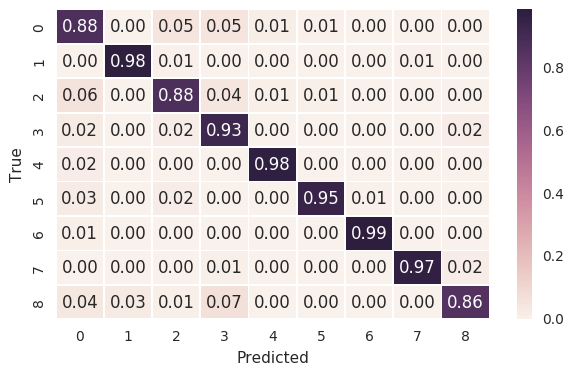

In [308]:
train_raw('j4_raw_ag.csv', shuffle_state=42)

Test score: 0.287910092663
Test accuracy: 0.902943018408
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_549 (Convolution2D (None, 8, 200, 20)    220         convolution2d_input_275[0][0]    
____________________________________________________________________________________________________
activation_549 (Activation)      (None, 8, 200, 20)    0           convolution2d_549[0][0]          
____________________________________________________________________________________________________
convolution2d_550 (Convolution2D (None, 8, 200, 40)    32040       activation_549[0][0]             
____________________________________________________________________________________________________
activation_550 (Activation)      (None, 8, 200, 40)    0           convolution2d_550[0][0]          
__________________________________

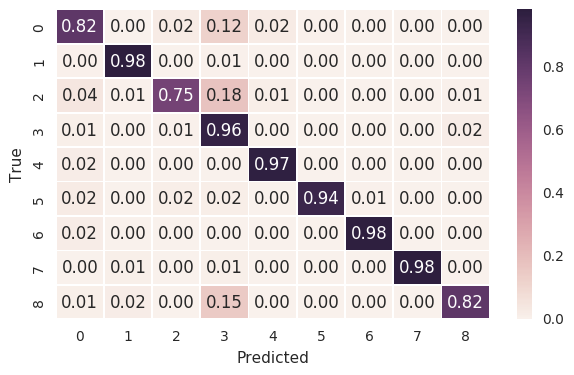

In [310]:
train_cp('raw_j4_ag_cp4.csv', labels, shuffle_state=42)

In [322]:
train_tucker('j4_raw_ag.csv', rank=[10, 2, 4], train_on='core', plot=False, shuffle_state=198)

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping


  0%|          | 0/15966 [00:00<?, ?it/s]

8 	  72200 	 TreadmillRunning

Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968


100%|██████████| 15966/15966 [09:23<00:00, 28.35it/s]


Compression Rate: 95.00
Root Mean Squared Distortion between tensor reconstruction and original tensor: 0.000%
Test score: 0.341442705009
Test accuracy: 0.884157795917
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_551 (Convolution2D (None, 10, 2, 20)     820         convolution2d_input_276[0][0]    
____________________________________________________________________________________________________
activation_551 (Activation)      (None, 10, 2, 20)     0           convolution2d_551[0][0]          
____________________________________________________________________________________________________
convolution2d_552 (Convolution2D (None, 10, 2, 40)     32040       activation_551[0][0]             
____________________________________________________________________________________________________
activation_552 (Activati

(<keras.models.Sequential at 0x7f632d65a110>, 0.88415779591701493, 95.0)

In [345]:
train_tucker('j4_raw_ag.csv', rank=[10, 2, 4], train_on='reconstruction', plot=False, shuffle_state=198)

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping
8 	  72200 	 TreadmillRunning


  0%|          | 0/15966 [00:00<?, ?it/s]


Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968


100%|██████████| 15966/15966 [09:33<00:00, 16.04it/s]


Compression Rate: 95.00
Root Mean Squared Distortion between tensor reconstruction and original tensor: 0.000%
Test score: 0.160800754253
Test accuracy: 0.947401377633
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_555 (Convolution2D (None, 8, 200, 20)    220         convolution2d_input_278[0][0]    
____________________________________________________________________________________________________
activation_555 (Activation)      (None, 8, 200, 20)    0           convolution2d_555[0][0]          
____________________________________________________________________________________________________
convolution2d_556 (Convolution2D (None, 8, 200, 40)    32040       activation_555[0][0]             
____________________________________________________________________________________________________
activation_556 (Activati

(<keras.models.Sequential at 0x7f6330e96d10>, 0.94740137763273191, 95.0)

In [1]:
train_tucker('j4_raw_ag.csv', rank=[20, 2, 4], train_on='reconstruction', plot=False, shuffle_state=198)

In [325]:
train_tucker('j4_raw_ag.csv', rank=[20, 2, 4], train_on='core', plot=False, shuffle_state=198)

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping


  0%|          | 0/15966 [00:00<?, ?it/s]

8 	  72200 	 TreadmillRunning

Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968


100%|██████████| 15966/15966 [09:32<00:00, 16.62it/s]


Compression Rate: 90.00
Root Mean Squared Distortion between tensor reconstruction and original tensor: 0.000%
Test score: 0.333515094749
Test accuracy: 0.87956585279
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_553 (Convolution2D (None, 20, 2, 20)     820         convolution2d_input_277[0][0]    
____________________________________________________________________________________________________
activation_553 (Activation)      (None, 20, 2, 20)     0           convolution2d_553[0][0]          
____________________________________________________________________________________________________
convolution2d_554 (Convolution2D (None, 20, 2, 40)     32040       activation_553[0][0]             
____________________________________________________________________________________________________
activation_554 (Activatio

(<keras.models.Sequential at 0x7f6330883410>, 0.87956585278965893, 90.0)

# GPU vs CPU training time benchmarks:

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping
8 	  72200 	 TreadmillRunning

Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968
Test score: 0.241832768885
Test accuracy: 0.931120851559
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 8, 200, 20)    220         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 8, 200, 20)    0           convolution2d_1[0][0]            
_______________________________________________________________________________________________

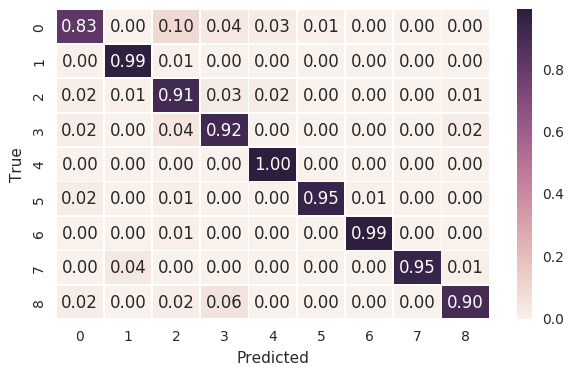

In [9]:
%%time 
# using GPU
train_raw('j4_raw_ag.csv', shuffle_state=42)

label 	  count 	 activity
0 	  508000 	 Downstairs
1 	  551000 	 Running
2 	  523000 	 Upstairs
3 	  558600 	 Walking
4 	  433800 	 Standing
5 	  409200 	 Biking
6 	  64000 	 GymBiking
7 	  73800 	 Jumping
8 	  72200 	 TreadmillRunning

Number of Activities with both Accelerometer and Gyroscope: 9
Number of blocks of 3D data at 200hz: 15968
Test score: 0.243557005219
Test accuracy: 0.921102066287
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 8, 200, 20)    220         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 8, 200, 20)    0           convolution2d_3[0][0]            
_______________________________________________________________________________________________

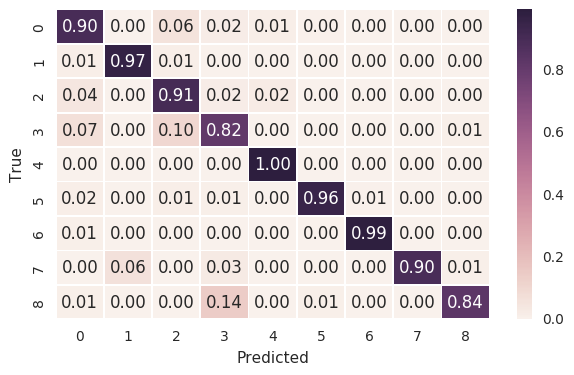

In [11]:
%%time 
# using CPU with ```with tf.device('/cpu:0'):```
train_raw('j4_raw_ag.csv', shuffle_state=42)

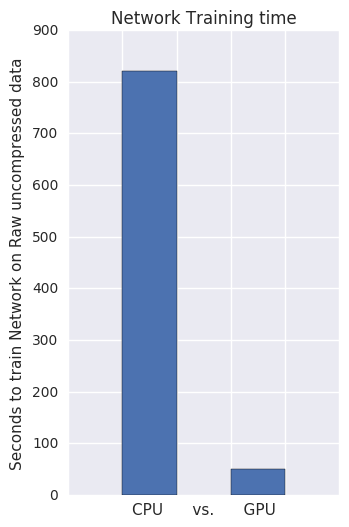

In [12]:
plt.figure(figsize=(3.5,6))
plt.bar([0.2, 0.6], [821, 51], width=0.2)
plt.xlim(0,1)
plt.ylabel('Seconds to train Network on Raw uncompressed data')
plt.xlabel('CPU      vs.      GPU')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.title('Network Training time')